In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

%matplotlib inline

### База даних IKEA.
1. Завантажте цей [набір даних IKEA.](https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-11-03/ikea.csv)
2. Виконайте дослідження для набору даних, включаючи описову статистику та візуалізації. Опишіть результати.
3. Грунтуючись на EDA та вашому здоровому глузді, виберіть дві гіпотези, які ви хочете перевірити/проаналізувати. Для кожної гіпотези перерахуйте нульову гіпотезу та інші можливі альтернативні гіпотези, розробіть тести, щоб розрізняти їх, та виконайте їх. Опишіть результати.
4. Навчіть модель передбачати ціну на меблі. 
- Вкажіть, які стовпці не слід включати в модель і чому. 
- Створіть конвеєр перехресної перевірки для навчання та оцінки моделі, включаючи (за потреби) такі кроки як, внесення пропущених значень та нормалізація.
- Запропонуйте методи підвищення продуктивності моделі. Опишіть результати.

In [65]:
data = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-11-03/ikea.csv', index_col=0)
data.head()

,item_id,name,category,price,old_price,sellable_online,link,other_colors,short_description,designer,depth,height,width
0,90420332,FREKVENS,Bar furniture,265.0,No old price,True,https://www.ikea.com/sa/en/p/frekvens-bar-tabl...,No,"Bar table, in/outdoor, 51x51 cm",Nicholai Wiig Hansen,NaN,99.0,51.0
1,368814,NORDVIKEN,Bar furniture,995.0,No old price,False,https://www.ikea.com/sa/en/p/nordviken-bar-tab...,No,"Bar table, 140x80 cm",Francis Cayouette,NaN,105.0,80.0
2,9333523,NORDVIKEN / NORDVIKEN,Bar furniture,2095.0,No old price,False,https://www.ikea.com/sa/en/p/nordviken-nordvik...,No,Bar table and 4 bar stools,Francis Cayouette,NaN,NaN,NaN
3,80155205,STIG,Bar furniture,69.0,No old price,True,https://www.ikea.com/sa/en/p/stig-bar-stool-wi...,Yes,"Bar stool with backrest, 74 cm",Henrik Preutz,50.0,100.0,60.0
4,30180504,NORBERG,Bar furniture,225.0,No old price,True,https://www.ikea.com/sa/en/p/norberg-wall-moun...,No,"Wall-mounted drop-leaf table, ...",Marcus Arvonen,60.0,43.0,74.0


# EDA

Видалимо колонки 'link','name', 'short_description',
оскільки вони не є достатньо корисними для подальшого дослідження

In [66]:
data = data.drop(['link','name', 'short_description'], axis = 1)

In [67]:
data.sellable_online.value_counts()

True     3666
False      28
Name: sellable_online, dtype: int64

Як бачимо, то колонка 'sellable_online' також не є достатньо репрезинтативною, тому видаляємо і її

In [68]:
data = data.drop('sellable_online', axis = 1)

In [69]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3694 entries, 0 to 3693
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   item_id       3694 non-null   int64  
 1   category      3694 non-null   object 
 2   price         3694 non-null   float64
 3   old_price     3694 non-null   object 
 4   other_colors  3694 non-null   object 
 5   designer      3694 non-null   object 
 6   depth         2231 non-null   float64
 7   height        2706 non-null   float64
 8   width         3105 non-null   float64
dtypes: float64(4), int64(1), object(4)
memory usage: 288.6+ KB


Розміри товарів ('depth','height','width') мають пусті значення

In [70]:
data.isnull().sum()

item_id            0
category           0
price              0
old_price          0
other_colors       0
designer           0
depth           1463
height           988
width            589
dtype: int64

In [71]:
data[['item_id','depth','height','width']].groupby(['item_id']).agg(lambda x: x).head(20)

,depth,height,width
item_id,,,
58487,NaN,86.0,57.0
91415,"[nan, nan]","[nan, nan]","[28.0, 28.0]"
102065,"[nan, nan]","[nan, nan]","[nan, nan]"
102452,NaN,157.0,NaN
105064,"[nan, nan]","[75.0, 75.0]","[37.0, 37.0]"
116595,37.0,214.0,96.0
121766,"[45.0, 45.0]","[102.0, 102.0]","[40.0, 40.0]"
141689,58.0,97.0,51.0
152282,30.0,45.0,39.0


Напишемо функцію для заміни пустих значень в стовчиках ('depth', 'height', 'width').\
Заміну будемо здійснювати по середнім значенням по кожній категорії категорії.

In [72]:
def nan_depth_height_width_dealer(input_df):
    
    local_df = data.copy()
    local_df
    
# вносимо зміни до даних NaN в стовчику 'depth'

    data_depth_grouped_wo_drops = local_df[['item_id','depth']].groupby(['item_id']).agg(lambda x: x)
    data_depth_grouped_w_drops = local_df[['item_id','depth']].dropna().groupby(['item_id']).agg(lambda x: x)
    median_depth_by_category = data[['category','depth']].dropna().groupby(['category']).median().round(1)

    res_d = []

    for ind in data_depth_grouped_wo_drops.index:
        if not (ind in data_depth_grouped_w_drops.index):
            res_d.append(ind) # перелік індекси з NaN
    
    edit_counter_d = 0

    for ind,(item_id, depth, category) in enumerate(zip(local_df.item_id, local_df.depth, local_df.category)):
        if math.isnan(depth) and  (item_id in res_d):
            local_df.at[ind, 'depth'] = median_depth_by_category.loc[[category]].depth[0]
                        
            edit_counter_d += 1
            continue
        
        if math.isnan(depth):
            local_df.drop([ind], inplace=True)
    print('number of changes in "depth": ', edit_counter_d)
    
# вносимо зміни до даних NaN в стовчику 'height'

    data_height_grouped_wo_drops = local_df[['item_id','height']].groupby(['item_id']).agg(lambda x: x)
    data_height_grouped_w_drops = local_df[['item_id','height']].dropna().groupby(['item_id']).agg(lambda x: x)
    median_height_by_category = data[['category','height']].dropna().groupby(['category']).median().round(1)

    res_h = []

    for ind in data_height_grouped_wo_drops.index:
        if not (ind in data_height_grouped_w_drops.index):
            res_h.append(ind) # перелік індекси з NaN
    
    edit_counter_h = 0

    for ind,(item_id, height, category) in enumerate(zip(local_df.item_id, local_df.height, local_df.category)):
        if math.isnan(height) and  (item_id in res_h):
            local_df.at[ind, 'height'] = median_height_by_category.loc[[category]].height[0]
                        
            edit_counter_h += 1
            continue
        
        if math.isnan(height):
            local_df.drop([ind], inplace=True)
    print('number of changes in "height": ', edit_counter_h)
    
# вносимо зміни до даних NaN в стовчику 'width'

    data_width_grouped_wo_drops = local_df[['item_id','width']].groupby(['item_id']).agg(lambda x: x)
    data_width_grouped_w_drops = local_df[['item_id','width']].dropna().groupby(['item_id']).agg(lambda x: x)
    median_width_by_category = data[['category','width']].dropna().groupby(['category']).median().round(1)

    res_w = []

    for ind in data_width_grouped_wo_drops.index:
        if not (ind in data_width_grouped_w_drops.index):
            res_w.append(ind) # перелік індекси з NaN
    
    edit_counter_w = 0

    for ind,(item_id, width, category) in enumerate(zip(local_df.item_id, local_df.width, local_df.category)):
        if math.isnan(width) and  (item_id in res_w):
            local_df.at[ind, 'width'] = median_width_by_category.loc[[category]].width[0]
                        
            edit_counter_w += 1
            continue
        
        if math.isnan(width):
            local_df.drop([ind], inplace=True)
    print('number of changes in "width": ', edit_counter_w)   
        
    return local_df

df = nan_depth_height_width_dealer(data)

number of changes in "depth":  1463
number of changes in "height":  988
number of changes in "width":  589


In [73]:
df.head()

,item_id,category,price,old_price,other_colors,designer,depth,height,width
0,90420332,Bar furniture,265.0,No old price,No,Nicholai Wiig Hansen,47.0,99.0,51.0
1,368814,Bar furniture,995.0,No old price,No,Francis Cayouette,47.0,105.0,80.0
2,9333523,Bar furniture,2095.0,No old price,No,Francis Cayouette,47.0,102.0,48.0
3,80155205,Bar furniture,69.0,No old price,Yes,Henrik Preutz,50.0,100.0,60.0
4,30180504,Bar furniture,225.0,No old price,No,Marcus Arvonen,60.0,43.0,74.0


Інший варіант коду для заміни пустих значень в стовчиках ('depth', 'height', 'width').

In [74]:
median_d = data.groupby(['category'])['depth'].median()
median_h = data.groupby(['category'])['height'].median()
median_w = data.groupby(['category'])['width'].median()

median_price = df.groupby(['category'])['price'].median()

data = data.set_index(['category'])
data['depth_1'] = data['depth'].fillna(median_d)
data['height_1'] = data['height'].fillna(median_h)
data['width_1'] = data['width'].fillna(median_w)
data['category_median_price'] = median_price
data = data.reset_index()

data.head()

,category,item_id,price,old_price,other_colors,designer,depth,height,width,depth_1,height_1,width_1,category_median_price
0,Bar furniture,90420332,265.0,No old price,No,Nicholai Wiig Hansen,NaN,99.0,51.0,47.0,99.0,51.0,445.0
1,Bar furniture,368814,995.0,No old price,No,Francis Cayouette,NaN,105.0,80.0,47.0,105.0,80.0,445.0
2,Bar furniture,9333523,2095.0,No old price,No,Francis Cayouette,NaN,NaN,NaN,47.0,102.0,48.0,445.0
3,Bar furniture,80155205,69.0,No old price,Yes,Henrik Preutz,50.0,100.0,60.0,50.0,100.0,60.0,445.0
4,Bar furniture,30180504,225.0,No old price,No,Marcus Arvonen,60.0,43.0,74.0,60.0,43.0,74.0,445.0


In [75]:
df.isnull().sum()

item_id         0
category        0
price           0
old_price       0
other_colors    0
designer        0
depth           0
height          0
width           0
dtype: int64

Перевіримо чи коретно було здійснено заміну значень

In [76]:
data[data.item_id == 102065]

,category,item_id,price,old_price,other_colors,designer,depth,height,width,depth_1,height_1,width_1,category_median_price
151,Beds,102065,495.0,No old price,No,IKEA of Sweden,NaN,NaN,NaN,88.0,84.0,140.0,1093.5
2560,Sofas & armchairs,102065,495.0,No old price,No,IKEA of Sweden,NaN,NaN,NaN,98.0,83.0,196.0,1268.5


In [77]:
df[df.item_id == 102065]

,item_id,category,price,old_price,other_colors,designer,depth,height,width
151,102065,Beds,495.0,No old price,No,IKEA of Sweden,88.0,84.0,140.0
2560,102065,Sofas & armchairs,495.0,No old price,No,IKEA of Sweden,98.0,83.0,196.0


In [78]:
median_depth_by_category = data[['category','depth']].dropna().groupby(['category']).median().round(1)
median_height_by_category = data[['category','height']].dropna().groupby(['category']).median().round(1)
median_width_by_category = data[['category','width']].dropna().groupby(['category']).median().round(1)

print(median_depth_by_category.loc['Beds'])
print(median_height_by_category.loc['Beds'])
print(median_width_by_category.loc['Beds'])
print(median_depth_by_category.loc['Sofas & armchairs'])
print(median_height_by_category.loc['Sofas & armchairs'])
print(median_width_by_category.loc['Sofas & armchairs'])

depth    88.0
Name: Beds, dtype: float64
height    84.0
Name: Beds, dtype: float64
width    140.0
Name: Beds, dtype: float64
depth    98.0
Name: Sofas & armchairs, dtype: float64
height    83.0
Name: Sofas & armchairs, dtype: float64
width    196.0
Name: Sofas & armchairs, dtype: float64


Напишемо функцію для приведення до "кращого" вигляду стовчика 'designer'

In [79]:
df.designer.value_counts()

IKEA of Sweden                                                                                                                                                                                                                                                                                                                                                                                                                  828
Ehlén Johansson                                                                                                                                                                                                                                                                                                                                                                                                                 161
Francis Cayouette                                                                                                                                               

In [80]:
def cleanDesigners(value, removeIKEA=False, emptyValue=np.nan):
    # Якщо значення не є str, то повертаємо саме значення
    if not isinstance(value, str):
        return value
    # Якщо рядок починається з цифри, то повертаємо пусте значення 
    if len(value)>0 and value[0].isdigit():
        return emptyValue
    # Розбиваємо рядок по / 
    designers = value.split("/")
    if removeIKEA:
        # Пробуємо видалити "IKEA of Sweden"
        try:
            designers.remove("IKEA of Sweden")
        except:
            pass
    if len(designers) > 0:
        # Повертаємо рядок відсортований по іменам дизайнерів
        return '/'.join(sorted(designers))
    else:
        # Або пустий рядок
        return emptyValue

In [81]:
df['clean_designer'] = df.designer.apply(cleanDesigners, args=(False, "IKEA of Sweden"))

In [82]:
df.clean_designer.value_counts()

IKEA of Sweden                                                     971
Ehlén Johansson                                                    161
Francis Cayouette                                                  151
Ehlén Johansson/IKEA of Sweden                                     145
Ola Wihlborg                                                       134
                                                                  ... 
Eva Lilja Löwenhielm/IKEA of Sweden/Jon Karlsson                     1
A Huldén/S Dahlman                                                   1
Ehlén Johansson/Fredriksson/Hilland/IKEA of Sweden/L Löwenhielm      1
Malin Unnborn                                                        1
Lars Norinder                                                        1
Name: clean_designer, Length: 199, dtype: int64

Побудуємо графіки для деяких параметрів

In [83]:
data = data.dropna()

price


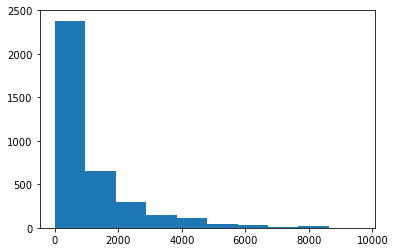

depth


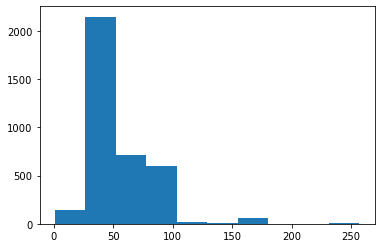

height


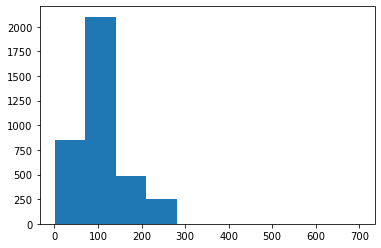

width


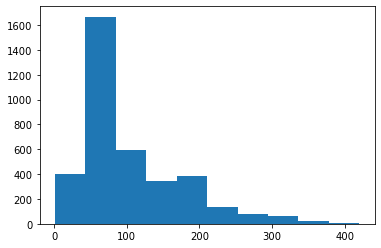

In [84]:
for col in ['price', 'depth', 'height', 'width']:
    print(col)
    plt.hist(df[col])
    plt.show()

[Text(0, 0, 'Bar furniture'),
 Text(1, 0, 'Beds'),
 Text(2, 0, 'Bookcases & shelving units'),
 Text(3, 0, 'Cabinets & cupboards'),
 Text(4, 0, 'Café furniture'),
 Text(5, 0, 'Chairs'),
 Text(6, 0, 'Chests of drawers & drawer units'),
 Text(7, 0, "Children's furniture"),
 Text(8, 0, 'Nursery furniture'),
 Text(9, 0, 'Outdoor furniture'),
 Text(10, 0, 'Room dividers'),
 Text(11, 0, 'Sideboards, buffets & console tables'),
 Text(12, 0, 'Sofas & armchairs'),
 Text(13, 0, 'Tables & desks'),
 Text(14, 0, 'Trolleys'),
 Text(15, 0, 'TV & media furniture'),
 Text(16, 0, 'Wardrobes')]

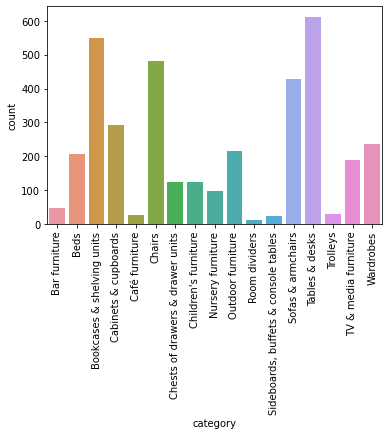

In [85]:
sns.countplot(x=df['category']).set_xticklabels(df['category'].unique(), rotation=90)

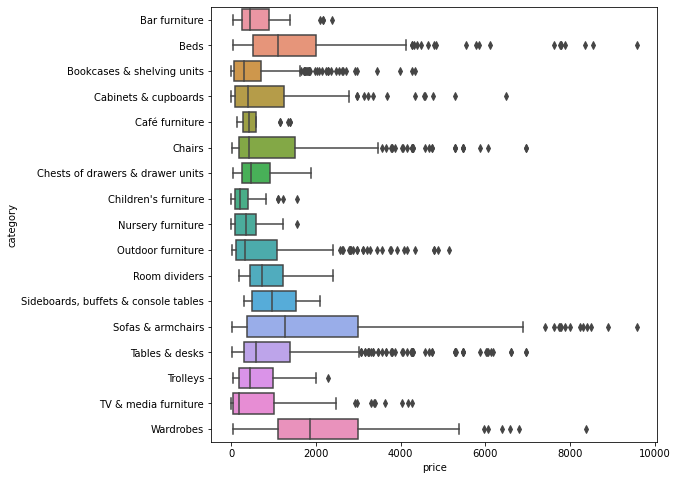

In [86]:
plt.subplots(figsize=(8,8))
sns.boxplot(data=df, x='price', y='category')
plt.show()

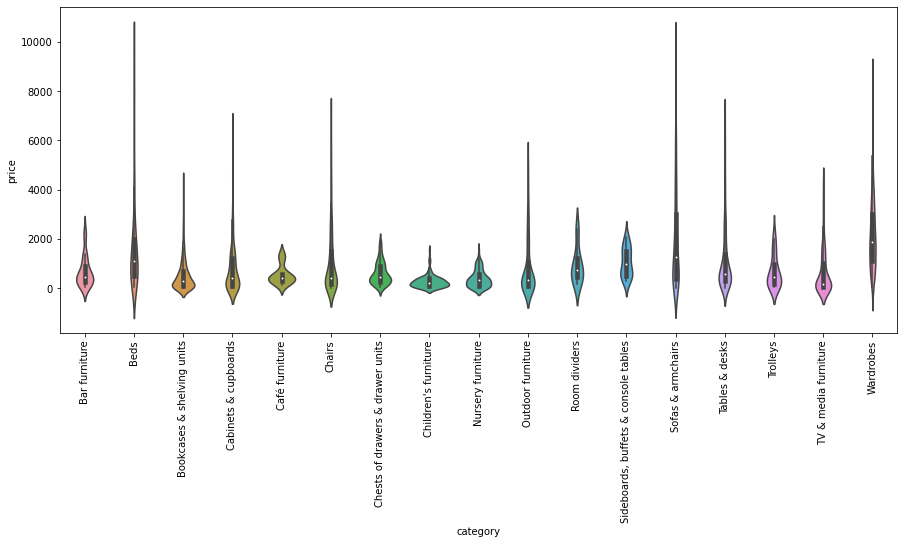

In [87]:
plt.subplots(figsize=(15,6))
sns.violinplot(data=df, y='price', x='category')
plt.xticks(rotation=90)
plt.show()

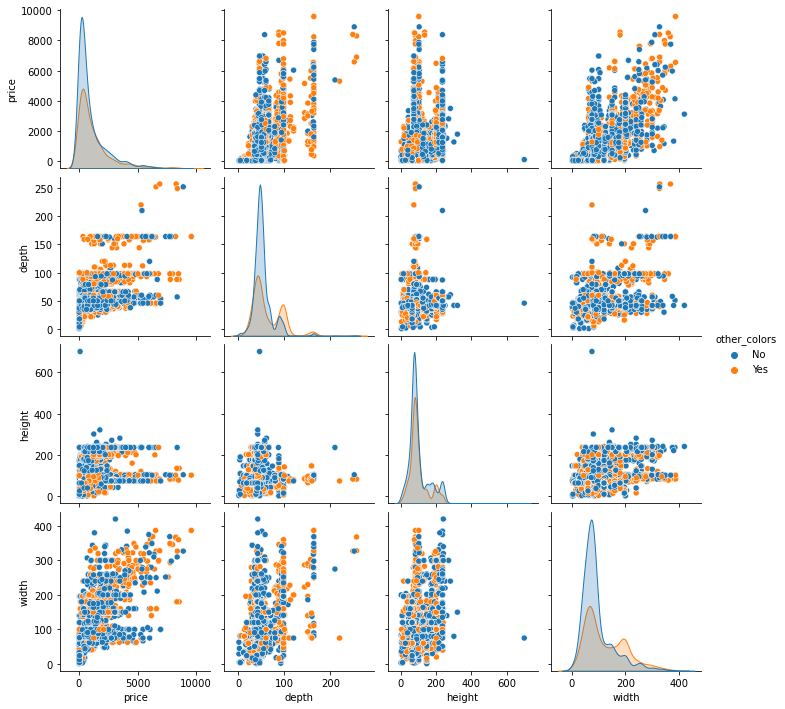

In [88]:
sns.pairplot(df[['price','depth','height','width','other_colors','category']], hue='other_colors')

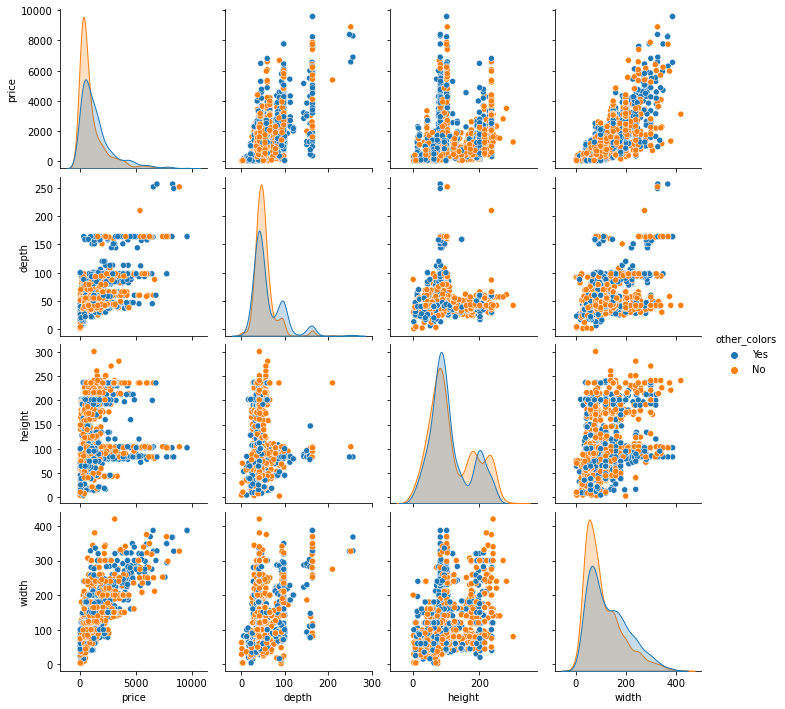

In [89]:
sns.pairplot(data[['price','depth','height','width','other_colors','category']], hue='other_colors')

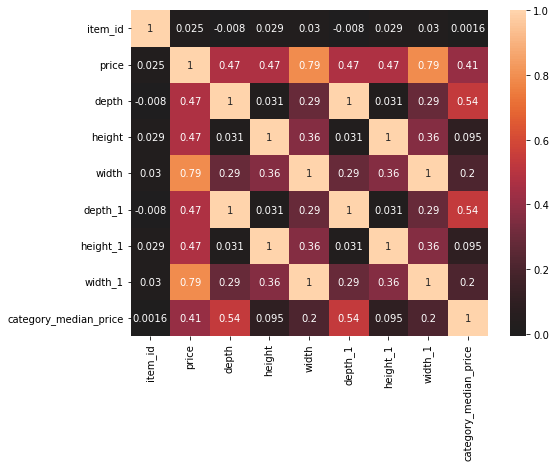

In [90]:
plt.figure(figsize=(8,6))
sns.heatmap(data.corr(method='spearman'), xticklabels=data.corr().columns, yticklabels=data.corr().columns, center=0, annot=True)
plt.show()

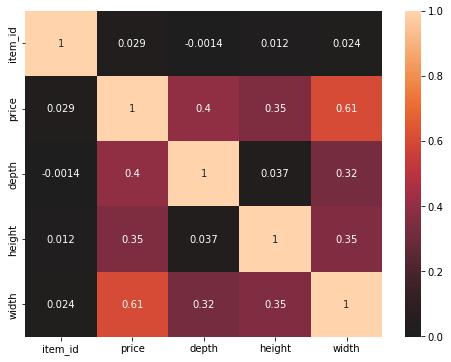

In [91]:
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(method='spearman'), xticklabels=df.corr().columns, yticklabels=df.corr().columns, center=0, annot=True)
plt.show()

# Перевірка гіпотез

In [92]:
from scipy import stats

# Гіпотеза № 1

Перевіримо гіпотезу Н0 про те чи мають ціни на стільці нормальний розподіл. Проведемо аналіз на даних з просто видаленими NaN (data) та даними без видалення (df)

(array([0.04276107, 0.11402952, 0.47037179, 0.84096774, 0.72693822,
        0.57014762, 0.27082012]),
 array([1.17609126, 1.50546811, 1.83484496, 2.1642218 , 2.49359865,
        2.8229755 , 3.15235235, 3.4817292 ]),
 <BarContainer object of 7 artists>)

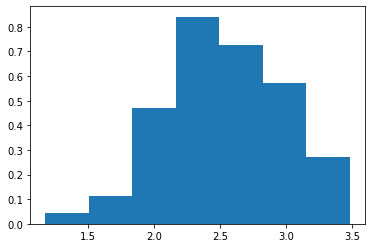

In [93]:
plt.hist(np.log10(data[data.category == 'Chairs'].price), bins=7,density=True)

In [94]:
h0_p_value = stats.shapiro(np.log10(data[data.category == 'Chairs'].price)).pvalue
print(h0_p_value)

0.2516082227230072


p-value вийшов достатньо великим (а = 0.05, 0.01), тому Н0 не відкидаємо - розподіл є нормальним

(array([0.13581341, 0.16715497, 0.3604279 , 0.61638395, 0.44400539,
        0.54847725, 0.24028527]),
 array([1.05690485, 1.45490718, 1.8529095 , 2.25091182, 2.64891415,
        3.04691647, 3.4449188 , 3.84292112]),
 <BarContainer object of 7 artists>)

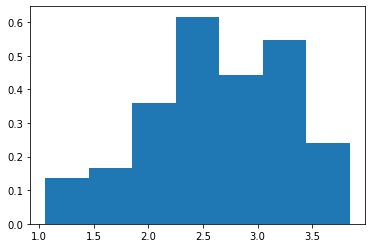

In [95]:
plt.hist(np.log10(df[df.category == 'Chairs'].price), bins=7,density=True)

In [96]:
h0_p_value = stats.shapiro(np.log10(df[df.category == 'Chairs'].price)).pvalue
print(h0_p_value)

2.2548881872808124e-07


p-value вийшов доволі малим (а = 0.05, 0.01), тому Н0 відкидаємо - розподіл НЕ є нормальним.

# Гіпотеза 2

Перевіримо гіпотезу Н0 про те, що ціни на товари з категорії "Children's furniture" не відрізняються від цін з категорії "Nursery furniture"

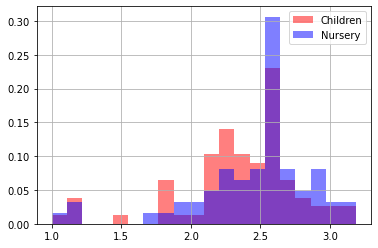

In [97]:
Children = data[data['category'] == "Children's furniture"]['price'].apply(np.log10)
Nursery = data[data['category'] == "Nursery furniture"]['price'].apply(np.log10)
Children.name, Nursery.name = 'Children', 'Nursery'

Children.hist(alpha=0.5, color='red', weights=[1./len(Children)]*len(Children), bins=20)
Nursery.hist(alpha=0.5, color='blue', weights=[1./len(Nursery)]*len(Nursery), bins=20)

plt.legend([Children.name, Nursery.name])

Бачимо, що розподіли йомовірно не є нормальними, тому перевіримо критерій Манна-Уітні (застосовується при ненормальних розподілах)

In [98]:
stats.mannwhitneyu(Children, Nursery).pvalue

0.06149142708700434

p-value більше 0.01 та 0.05, тому гіпотезу Н0 не відкидаємо

# Передбачення ціни на меблі

In [99]:
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

З початкового датафрейму ми вже видалили "некорисні" стовбчики - 'link', 'name', 'short_description', 'sellable_online'.

Також замінили пусті значення в стовбчиках 'depth','height','width' на середні значення по кожній категорії.

Додамо нових стовпчиків до датафрейму - середню ціну по кожній категорії, середню ціну по кожному дизайнеру та перетворимо дані стовбчика "other_colors" в нулі та одиниці

In [100]:
df = df.set_index(['category'])
df['category_median_price'] = df.groupby(['category'])['price'].median()
df = df.reset_index()

df = df.set_index(['clean_designer'])
df['designer_median_price'] = df.groupby(['clean_designer'])['price'].median()
df = df.reset_index()

df["other_colors_0_1"] = df["other_colors"].map(dict(Yes=1, No=0))
df = df.drop('item_id', axis = 1)

df.head()

,clean_designer,category,price,old_price,other_colors,designer,depth,height,width,category_median_price,designer_median_price,other_colors_0_1
0,Nicholai Wiig Hansen,Bar furniture,265.0,No old price,No,Nicholai Wiig Hansen,47.0,99.0,51.0,445.0,265.0,0
1,Francis Cayouette,Bar furniture,995.0,No old price,No,Francis Cayouette,47.0,105.0,80.0,445.0,458.0,0
2,Francis Cayouette,Bar furniture,2095.0,No old price,No,Francis Cayouette,47.0,102.0,48.0,445.0,458.0,0
3,Henrik Preutz,Bar furniture,69.0,No old price,Yes,Henrik Preutz,50.0,100.0,60.0,445.0,495.0,1
4,Marcus Arvonen,Bar furniture,225.0,No old price,No,Marcus Arvonen,60.0,43.0,74.0,445.0,150.0,0


In [102]:
X = df[['depth','width','height', 'category_median_price', 'designer_median_price', 'other_colors_0_1']]
Y = df['price']
X_train, X_test, Y_train, Y_test = sk.model_selection.train_test_split(X, Y, test_size=0.2, random_state=42)

In [104]:
model = DecisionTreeRegressor(max_depth = 10, random_state=42)
model.fit(X_train, Y_train)
predict_1 = model.predict(X_test)

print('DecisionTreeRegressor')
print('R^2 : {:.5f}'.format(model.score(X_test, Y_test)))
print('MAE : {:.5f}'.format(sk.metrics.mean_absolute_error(predict_1, Y_test)))
print('MSE : {:.5f}'.format(np.sqrt(sk.metrics.mean_squared_error(predict_1, Y_test))))

DecisionTreeRegressor
R^2 : 0.78003
MAE : 357.22006
MSE : 651.15103


In [106]:
model = KNeighborsRegressor(n_neighbors=16)
model.fit(X_train, Y_train)
predict_2 = model.predict(X_test)

print('KNeighborsRegressor')
print('R^2 : {:.5f}'.format(model.score(X_test, Y_test)))
print('MAE : {:.5f}'.format(sk.metrics.mean_absolute_error(predict_2, Y_test)))
print('MSE : {:.5f}'.format(np.sqrt(sk.metrics.mean_squared_error(predict_2, Y_test))))

KNeighborsRegressor
R^2 : 0.71362
MAE : 421.49250
MSE : 742.96598


In [107]:
model = RandomForestRegressor(random_state=42)
model.fit(X_train, Y_train)
predict_3 = model.predict(X_test)

print('RandomForestRegressor')
print('R^2 : {:.5f}'.format(model.score(X_test, Y_test)))
print('MAE : {:.5f}'.format(sk.metrics.mean_absolute_error(predict_3, Y_test)))
print('MSE : {:.5f}'.format(np.sqrt(sk.metrics.mean_squared_error(predict_3, Y_test))))


RandomForestRegressor
R^2 : 0.83149
MAE : 296.15976
MSE : 569.91750


In [108]:
model = GradientBoostingRegressor()
model.fit(X_train, Y_train)
predict_4 = model.predict(X_test)

print('GradientBoostingRegressor')
print('R^2 : {:.5f}'.format(model.score(X_test, Y_test)))
print('MAE : {:.5f}'.format(sk.metrics.mean_absolute_error(predict_4, Y_test)))
print('MSE : {:.5f}'.format(np.sqrt(sk.metrics.mean_squared_error(predict_4, Y_test))))

GradientBoostingRegressor
R^2 : 0.80952
MAE : 361.15451
MSE : 605.93247


Найкращий результат RandomForestRegressor (R^2 : 0.83149)

Для покращення моделі необхідно більше уваги зосередити на стовпчиках дизайнерів та габаритів товару (можна спробувати витягнути з стовпчика 'short_description')